In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.externals import joblib

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

from Autoencoder_Utils import print_features_histograms, plot_difference_displ, print_features_histograms_displ

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.objectives import binary_crossentropy, mse
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)
%matplotlib inline

Using TensorFlow backend.


## Read data

In [3]:
DATA_PATH = "./csv/"

In [31]:
# xgb_train = pd.read_csv(DATA_PATH+"xgb_train_data.csv", index_col=0)
vae_train_unscaled = pd.read_csv(DATA_PATH+"vae_train.csv", index_col=0)
vae_test_unscaled = pd.read_csv(DATA_PATH+"vae_test.csv", index_col=0)
# vae_train = pd.read_csv(DATA_PATH+"vae_train_scaled.csv", index_col=0)
# vae_test = pd.read_csv(DATA_PATH+"vae_test_scaled.csv", index_col=0)

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [13]:
vars_list = list(vae_train)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

## AE

In [9]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5*z_log_var) * epsilon

def create_vae_aux(n_features, encoding_dim, n_aux_features=5, n_mc_features=6, p_drop=0.5, n_layers=3, thickness=2):
    # Encoder
    inputs = Input(shape=(n_features, ), name='main_input')
    aux_inputs = Input(shape=(n_aux_features, ), name='aux_inputs')
    mc_inputs = Input(shape=(n_mc_features, ), name='mc_inputs')
    
    x = keras.layers.concatenate([inputs, aux_inputs, mc_inputs])

    for i in range(n_layers - 1):
        x = Dense(thickness * n_features // (i+1), activation='relu')(x)
        x = keras.layers.concatenate([x, aux_inputs, mc_inputs])

    
    x = Dense(thickness * encoding_dim, activation='relu')(x)
    x = keras.layers.concatenate([x, aux_inputs, mc_inputs])

    encoded_mu = Dense(encoding_dim, name='encoded_mu')(x)
    encoded_sigma = Dense(encoding_dim, name='encoded_sigma')(x)
    encoded = Lambda(sampling, output_shape=(encoding_dim,), name='encoded')([encoded_mu, encoded_sigma])

    
    # Decoder
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded, aux_inputs, mc_inputs])
    x = Dense(thickness * encoding_dim, activation='relu')(x)
    
    for i in range(n_layers - 2, -1, -1):
        x = keras.layers.concatenate([x, aux_inputs, mc_inputs])
        x = Dense(thickness * n_features // (i+1), activation='relu')(x)
        
    decoded = Dense(n_features, activation='sigmoid')(x)
    
    
    # Models
    encoder = Model([inputs, aux_inputs, mc_inputs], [encoded_mu, encoded_sigma, encoded], name="encoder")
    decoder = Model([input_encoded, aux_inputs, mc_inputs], decoded, name="decoder")
    
    outputs = decoder([encoder([inputs, aux_inputs, mc_inputs])[2], aux_inputs, mc_inputs])
    autoencoder = Model(
        [inputs, aux_inputs, mc_inputs], outputs, name="autoencoder"
    )

    # opt
    optimizer_adam = optimizers.Adam(lr=0.001)
    
    # loss
    reconstruction_loss = binary_crossentropy(inputs, outputs)
    reconstruction_loss *= n_features
    kl_loss = 1 + encoded_sigma - K.square(encoded_mu) - K.exp(encoded_sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss) 
    autoencoder.add_loss(vae_loss)
    autoencoder.compile(optimizer=optimizer_adam)
    
    return autoencoder, encoder, decoder

## Train ae

In [11]:
l_encoding_dim = [3, 6]

In [15]:
l_score = []
val_size = 0.2

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
le_mc = LabelBinarizer()

train_input = vae_train[vars_list_input].values
train_aux   = vae_train[vars_list_aux].values
train_MC    = vae_train[vars_list_MC].values.ravel()

le_mc.fit(train_MC)
train_MC = le_mc.transform(train_MC)

test_input = vae_test[vars_list_input].values
test_aux   = vae_test[vars_list_aux].values
test_MC    = vae_test[vars_list_MC].values.ravel()
test_MC = le_mc.transform(test_MC)

In [45]:
joblib.dump(le_mc, os.path.join('preprocessors', "le_mc") + ".pkl")

['preprocessors/le_mc.pkl']

In [17]:
%%time
nb_epoch = 50
batch_size = 256
n_layers = 4
thickness = 64

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=3, mode='min')
# tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) # you can try to run this visualization

save_decoded_dict = {}
save_encoded_dict = {}   
    
for encoding_dim in tqdm(l_encoding_dim):
    print("encoding_dim : ", encoding_dim)

    autoencoder, encoder, decoder = create_vae_aux(
        train_input.shape[1], encoding_dim, 
        n_aux_features=train_aux.shape[1], n_layers=n_layers, thickness=thickness
    )
    
#     print(encoder.summary())
#     print(decoder.summary())
    
    checkpointer = keras.callbacks.ModelCheckpoint(
                    filepath="./checkpoints/vae_bc_{}.hdf5".format(encoding_dim), 
                    verbose=0, 
                    save_best_only=True)

    history = autoencoder.fit(
        [train_input, train_aux, train_MC], 
        epochs=nb_epoch, batch_size=batch_size,
        shuffle=True, verbose=1,
        validation_split=val_size, callbacks =[early_stopping, checkpointer]
    )
    
#     autoencoder.load_weights("./checkpoints/vae_bc_{}.hdf5".format(encoding_dim))

    score = autoencoder.evaluate([test_input, test_aux, test_MC], batch_size=batch_size)
    l_score.append(score)

    encoded_test = encoder.predict([test_input, test_aux, test_MC])
    decoded_test = decoder.predict([encoded_test[2], test_aux, test_MC]) 

    save_decoded_dict[encoding_dim] = decoded_test.astype(np.float64)
    save_encoded_dict[encoding_dim] = np.array(encoded_test).astype(np.float64)


  0%|          | 0/2 [00:00<?, ?it/s]

encoding_dim :  3
Train on 1178029 samples, validate on 294508 samples
Epoch 1/50
1178029/1178029 [==============================] - 130s 111us/step - loss: 9.2700 - val_loss: 9.1272
Epoch 2/50
1178029/1178029 [==============================] - 124s 105us/step - loss: 9.1202 - val_loss: 9.0975
Epoch 3/50
1178029/1178029 [==============================] - 124s 105us/step - loss: 9.0798 - val_loss: 9.0487
Epoch 4/50
1178029/1178029 [==============================] - 124s 105us/step - loss: 9.0167 - val_loss: 8.9937
Epoch 5/50
1178029/1178029 [==============================] - 125s 106us/step - loss: 8.9807 - val_loss: 8.9984
Epoch 6/50
1178029/1178029 [==============================] - 124s 105us/step - loss: 8.9659 - val_loss: 8.9368
Epoch 7/50
1178029/1178029 [==============================] - 123s 105us/step - loss: 8.9501 - val_loss: 8.9556
Epoch 8/50
1178029/1178029 [==============================] - 123s 105us/step - loss: 8.9414 - val_loss: 8.9258
Epoch 9/50
1178029/1178029 [=====

 50%|█████     | 1/2 [41:54<41:54, 2514.80s/it]

encoding_dim :  6
Train on 1178029 samples, validate on 294508 samples
Epoch 1/50
1178029/1178029 [==============================] - 130s 110us/step - loss: 9.2886 - val_loss: 9.1439
Epoch 2/50
1178029/1178029 [==============================] - 128s 109us/step - loss: 9.1205 - val_loss: 9.1236
Epoch 3/50
1178029/1178029 [==============================] - 128s 109us/step - loss: 9.0846 - val_loss: 9.0795
Epoch 4/50
1178029/1178029 [==============================] - 128s 109us/step - loss: 9.0271 - val_loss: 9.0181
Epoch 5/50
1178029/1178029 [==============================] - 128s 109us/step - loss: 8.9925 - val_loss: 8.9765
Epoch 6/50
1178029/1178029 [==============================] - 128s 109us/step - loss: 8.9659 - val_loss: 8.9592
Epoch 7/50
1178029/1178029 [==============================] - 128s 108us/step - loss: 8.9524 - val_loss: 8.9397
Epoch 8/50
1178029/1178029 [==============================] - 129s 109us/step - loss: 8.9423 - val_loss: 8.9419
Epoch 9/50
1178029/1178029 [=====

100%|██████████| 2/2 [1:06:06<00:00, 1983.20s/it]

CPU times: user 58min 27s, sys: 17min 26s, total: 1h 15min 53s
Wall time: 1h 6min 6s


In [ ]:
scalers = {}
for var in (vars_list_input + vars_list_aux):
    scalers[var] = {
        'std': joblib.load(os.path.join('preprocessors', "VAE_scaler_std_"+var) + ".pkl"),
        'max': joblib.load(os.path.join('preprocessors', "VAE_scaler_max_"+var) + ".pkl")
    }

save_decoded_dict_dec = {}
for encoding_dim in save_decoded_dict:
    tmp_decoded_unscaled = save_decoded_dict[encoding_dim].copy()
    for i, var in enumerate(vars_list_input):
        tmp_decoded_unscaled[:, i] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(tmp_decoded_unscaled[:, i].reshape(-1, 1))
        ).reshape(-1)
    save_decoded_dict_dec[encoding_dim] = tmp_decoded_unscaled

******************** 3 ********************


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


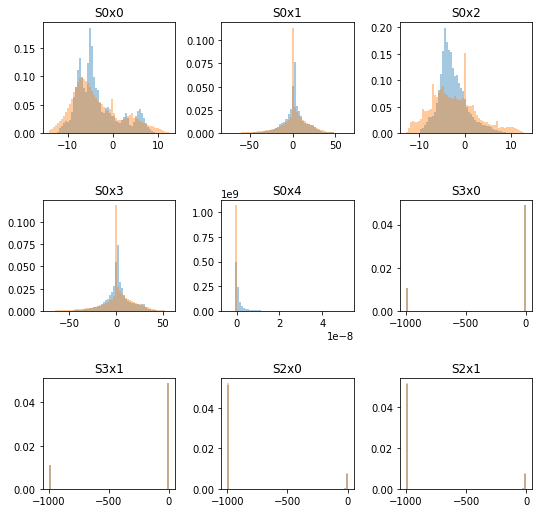

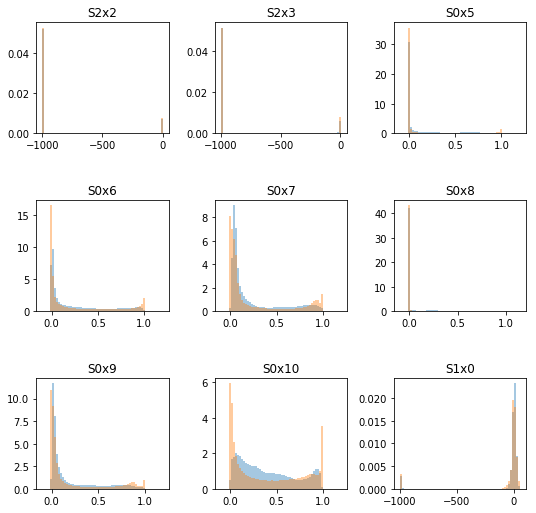

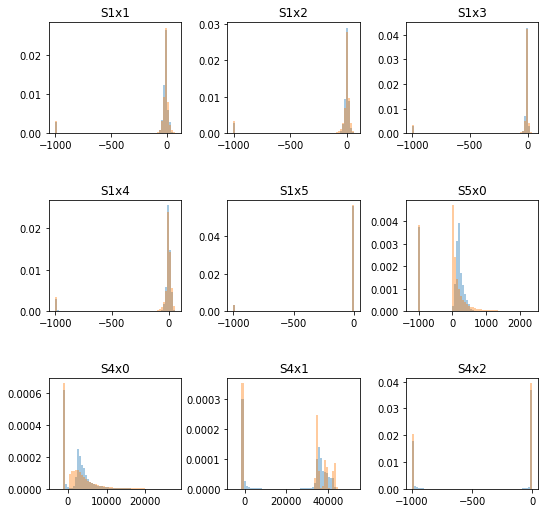

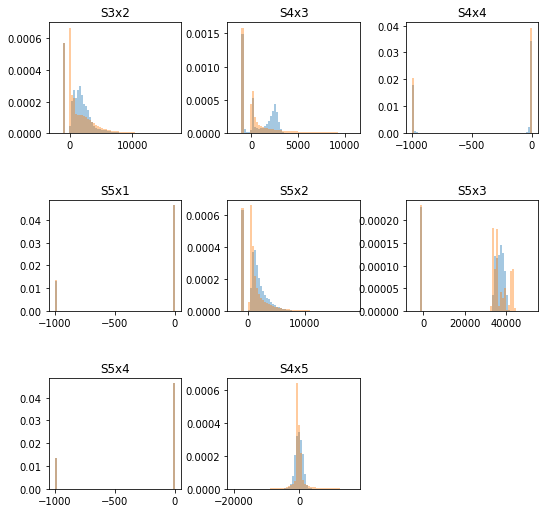

******************** 6 ********************


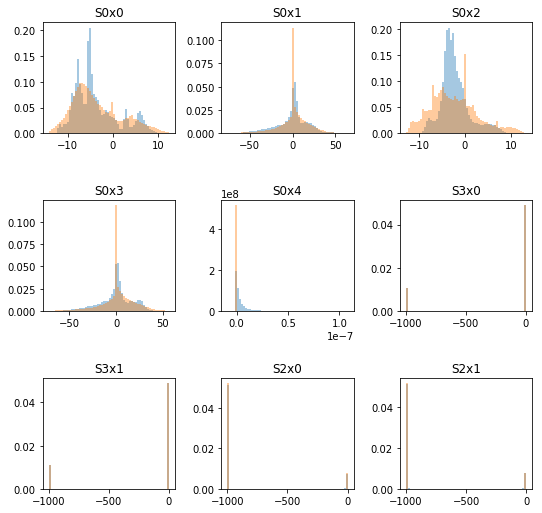

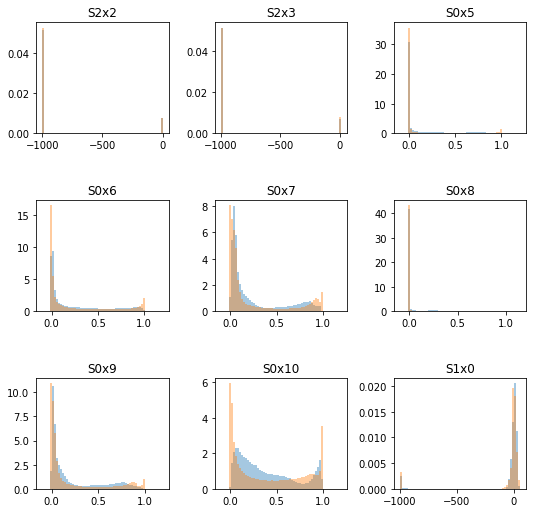

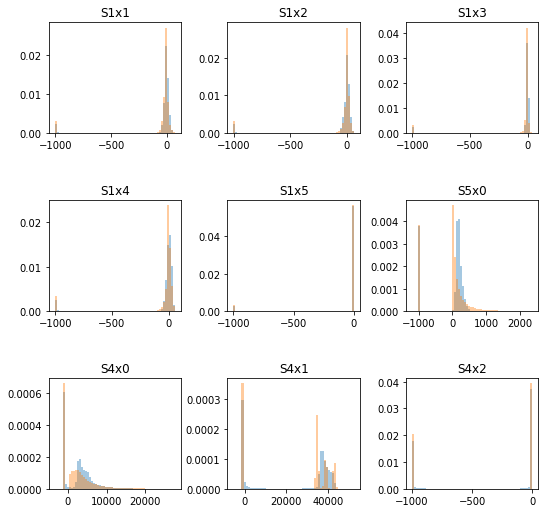

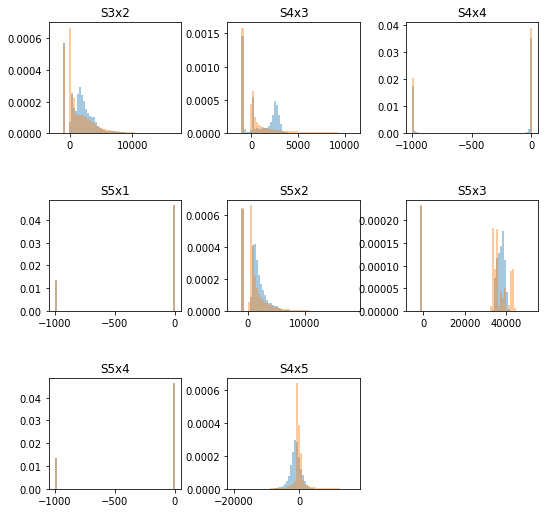

In [43]:
# The following plots show the orignal distributions in orange and the decoded distributions in blue.
# If the autoencoder has not lost a lot of information, these should lie on top of each other

rename_dict = {}
for i, e in enumerate(range(18)):
    rename_dict[e] = vars_list_input[i]
    
    
for encoding_dim in l_encoding_dim:
    print('*' * 20, encoding_dim, '*' * 20)
    
    df_temp = pd.DataFrame(save_decoded_dict_dec[encoding_dim], columns=vars_list_input)
    df_temp_input = vae_test_unscaled[vars_list_input].reset_index().drop("index", axis=1)

    df_temp.rename(columns=rename_dict, inplace=True)
    df_temp_input.rename(columns=rename_dict, inplace=True)

    print_features_histograms_displ(
        df_temp, target=df_temp_input, 
#         save_filename="_VAE_{1}_orig_uncom_distribs_{0}.png".format(TYPE, encoding_dim)
    )
    plt.show()

## Exploring latent space of VAE

In [30]:
from collections import defaultdict

test_inpits = defaultdict(list)
test_auxs = defaultdict(list)
test_mcs = defaultdict(list)
for x, (y, z) in zip(test_input, zip(test_aux, test_MC)):
    test_inpits[list(z).index(1)].append(x)
    test_auxs[list(z).index(1)].append(y)
    test_mcs[list(z).index(1)].append(z)

In [31]:
encoded = {}
y = []
for i, pid in enumerate(test_inpits.keys()):
    encoded[pid] = encoder.predict([test_inpits[pid][:1000], test_auxs[pid][:1000], test_mcs[pid][:1000]])
    y.extend([i]*1000)

In [32]:
encoded_values = np.concatenate(list(encoded.values()), axis=1)

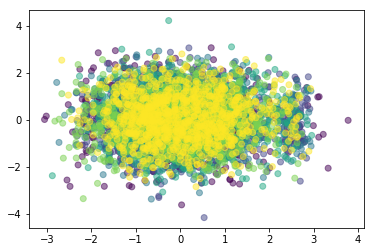

In [35]:
plt.scatter(encoded_values[2][:, 0], encoded_values[2][:, 1], c=np.array(y), alpha=0.5)
plt.show()

## Saving

In [44]:
# Save what you want to retain to this dictionary
retain_dict = {}
retain_dict['save_decoded_dict'] = save_decoded_dict
retain_dict['save_encoded_dict'] = save_encoded_dict

retain_dict['test_input'] = test_input.astype(np.float64)
retain_dict['test_aux'] = test_aux.astype(np.float64)
retain_dict['test_MC'] = test_MC

retain_dict['l_score'] = l_score

retain_dict['vars_list_input'] = vars_list_input
retain_dict['vars_list_aux'] = vars_list_aux
retain_dict['vars_list_mc'] = vars_list_MC

retain_dict['save_decoded_dict_dec'] = save_decoded_dict_dec

pickle.dump(retain_dict, open("VAE_retain_dict.p", "wb"))